<a href="https://colab.research.google.com/github/vggd18/mlp-cnn-cifar10/blob/main/CIFAR10_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 with CNNs
Simple starter notebook to benchmark your own CNN with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [1]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [2]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [3]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Defining convolution blocks
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    # Defining pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully-connected layers
    self.fc_hidden1 = nn.Linear(64 * 8 * 8, 120)
    self.fc_hidden2 = nn.Linear(120, 84)
    self.fc_output = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(nn.ReLU()(self.conv1(x)))
    x = self.pool(nn.ReLU()(self.conv2(x)))
    x = x.view(x.size(0), -1) # flatten to input into fc layers
    x = nn.ReLU()(self.fc_hidden1(x))
    x = nn.ReLU()(self.fc_hidden2(x))
    x = self.fc_output(x)
    return x

In [4]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [5]:
#@title Hyperparameters

learning_rate = 0.005
num_epochs = 50
batch_size = 64

loss_function = nn.CrossEntropyLoss()

In [6]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title Training loop

# Build the model
cnn = CNN()
cnn.cuda()

# Setting optimizer up
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # Forward pass
    optimizer.zero_grad()
    outputs = cnn(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  # Loss avrg
  epoch_loss /= len(train_loader)
  tqdm.write(f' Epoch {epoch+1} average loss: {epoch_loss:.4f}')

  # Early stopping using loss
  if epoch_loss < best_loss:
    best_loss = epoch_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

  2%|▏         | 1/50 [00:15<12:54, 15.81s/it]

 Epoch 1 average loss: 1.3812


In [ ]:
#@title  Avaliação geral

cnn.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores(true_labels, predictions)
print("🏁 Métricas globais do modelo:\n", scores)


🏁 Métricas globais do modelo:
 {'accuracy': 0.4804, 'balanced_accuracy': np.float64(0.48040000000000005), 'precision': 0.49356522953887105, 'recall': 0.4804, 'f1_score': 0.4724329519889024}


In [ ]:
#@title  Acurácia por classe

classes = test_dataset.classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

predictions_tensor = torch.tensor(predictions)
true_tensor = torch.tensor(true_labels)

for i in range(len(true_labels)):
    label = true_tensor[i]
    pred = predictions_tensor[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"Acurácia da classe {classes[i]:10s}: {acc:.2f}%")


Acurácia da classe airplane  : 47.70%
Acurácia da classe automobile: 70.10%
Acurácia da classe bird      : 27.10%
Acurácia da classe cat       : 31.40%
Acurácia da classe deer      : 55.90%
Acurácia da classe dog       : 16.60%
Acurácia da classe frog      : 46.20%
Acurácia da classe horse     : 58.60%
Acurácia da classe ship      : 63.90%
Acurácia da classe truck     : 62.90%


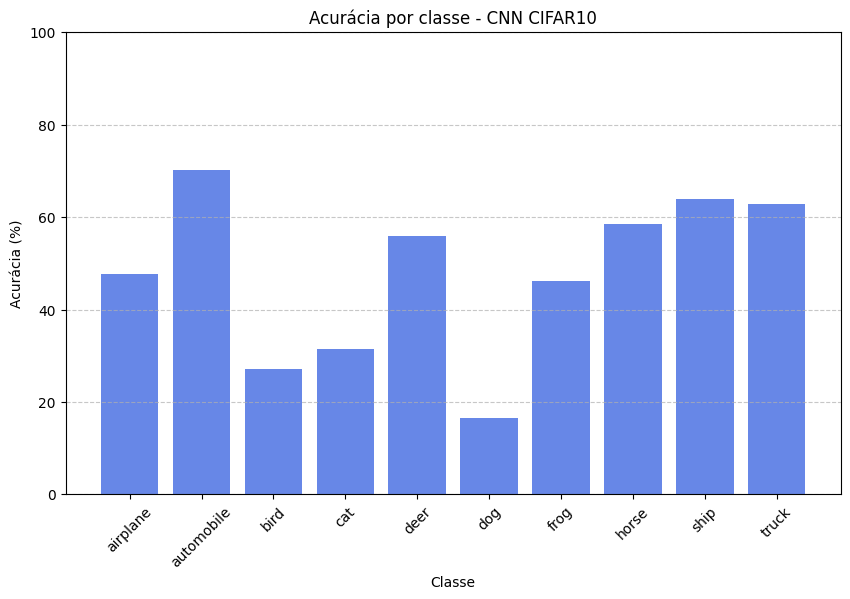

In [ ]:
#@title Gráfico de acurácia por classe

accuracies = [100 * class_correct[i] / class_total[i] for i in range(10)]

plt.figure(figsize=(10,6))
plt.bar(classes, accuracies, color='royalblue', alpha=0.8)
plt.xlabel('Classe')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia por classe - CNN CIFAR10')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
